In [7]:
import pandas as pd 
import numpy as np
from Response_Spectrum import *
from Base_Isolation_Calculation import *




In [8]:
def Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, epsilon):
   
    
    """
    m: Number of supports
    
    n: Number of girders per support
    
    n_c=[0,3,3,0]: Number of columns per support
    ** abutment1, 2 there are no columns
        number of columns = 3 in each pie 1 and 2 
        
    q:    percent of the bridge weight
    
    k:  the increased parameter of  post-yield stiffness      
    
    W_SS: Weight of superstructure including railings, curbs,and barriers to the permanent loads
    
    W_PP: Weight of piers participating with superstructure in dynamic response
    
    W_eff= W_SS + W_PP: Effective weight
    
    W=[W_1,W_2,...,W_m]: Weight of superstructure at each support
    
    K_sub=[K_sub_abut1, K_sub_pie1, K_sub_pie2, K_sub_abut2]: Stiffness of each support in both longitudinal and transverse directions of the bridge
    ** For the abutments, take Ksub,j to be a large number, say 10,000 kips/in.
    
    angle_skew: Angle of skew
    
    PGA,S_1, S_S: Acceleration coefficients for bridge site are given in design statement
    
    SiteClass:  "A", "B", "C","D","E"
    
    epsilon: tolerance
    
    d: set initial guess for the first iteration
 
    """
    
    # Round the values in each column to n decimal places
    def round_values(x,n):
        try:
            return round(x, n)
        except:
            return x

    # Apply the e-4 formatting to numeric columns
    def scientific_format(x):
        try:
            float_value = float(x)
            return '{:.2e}'.format(float_value).replace('+', '')
        except:
            return x


    ##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # B2.1.1—Step A: Identifty Bridge Data
    ## B2.1.1.2—Step A2: Seismic Hazard
    
    
    # B2.1.2—STEP B: ANALYZE BRIDGE FOR EARTHQUAKE LOADING IN LONGITUDINAL DIRECTION
    ## B2.1.2.1—STEP B1: SIMPLIFIED METHOD
    ### B2.1.2.1.1—Step B1.1: Initial System Displacement and Properties
        
    ##%% Assume that the initial value of displacement d approximates 2.0
    #d=2.0
    i=1
    
    d=10*S_D1
    
    data={}
  
    while True:
        
        #print(f'iteration:{i} ')
        #print(f'd={d}')
        
        ##%% Calculate characteristic strength, Q_d
        Q_d=q*W_SS

        ##%% Calculate Post-yield stiffness, K_d
        K_d=k*(W_SS/d)

        ### B2.1.2.1.2—Step B1.2: Initial Isolator Properties at Supports

        ##%% Calculate the characteristic strength, Q_dj

        Q_dj=[Q_d*(W[j]/W_SS) for j in range(m)]

        ##%% Calculate postelastic stiffness, K_dj

        K_dj= [K_d*(W[j]/W_SS) for j in range(m)]
      

        ### B2.1.2.1.3—Step B1.3: Effective Stiffness of Combined Pier and Isolator System

        ##%% Calculate alpha_j

        alpha_j = [(K_dj[j]*d+Q_dj[j])/(K_sub[j]*d-Q_dj[j]) for j in range(m)]

        ##%% Calculate the effective stiffness, K_effj

        K_effj=[(alpha_j[j]*K_sub[j])/(1+alpha_j[j]) for j in range(m)]

        ### B2.1.2.1.4—Step B1.4: Total Effective Stiffness

        ##%% Calculate the total effective stiffness, Keff, of the bridge:

        K_eff= sum(K_effj)
        #print(f'K_eff: {K_eff}')

        ### B2.1.2.1.5—Step B1.5: Isolation System Displacement at Each Suppor

        ##%% Calculate the displacement of the isolation system, d_isolj

        d_isolj=  [d/(1+ alpha_j[j]) for j in range(m)]
        
        #print(f'd_isolj: {d_isolj}')

        ### B2.1.2.1.6—Step B1.6: Isolation System Stiffness at Each Support

        ##%% Calculate the effective stiffness of the isolation system at support “j”, Kisol,j, for all supports

        K_isolj=[Q_dj[j]/d_isolj[j]+ K_dj[j] for j in range(m)]

        ### 2.1.2.1.7—Step B1.7: Substructure Displacement at Each Support, d_subj

        d_subj= [d- d_isolj[j] for j in range(m)]

        ### B2.1.2.1.8—Step B1.8: Lateral Load in Each Substructure Support

        ##%% Calculate the shear at support “j”, Fsub,j, for all supports:

        F_subj= [K_sub[j]* d_subj[j] for j in range(m)]

        ### B2.1.2.1.9—Step B1.9: Column Shear Force at Each Support

        F_coljk = [F_subj[j]/n_c[j] if n_c[j] != 0 else 0 for j in range(m)]

        ### B2.1.2.1.10—Step B1.10: Effective Period and Damping Ratio

        ##%% Calculate the effective period, T_eff 

        W_eff= W_SS + W_PP #  Effective weight, W_eff
        g=386.4 # (in./s^2) or 9.815(m/s^2)

        T_eff=2*np.pi* (W_eff/(g*K_eff))**(1/2)
        #print(f'T_eff: {T_eff}')

        ##%% Calculate the viscous damping ratio, ξ , of the bridge

        d_yj=[0]*m # taking d_yj=0

        numerator=2*sum([Q_dj[j]*(d_isolj[j]-d_yj[j]) for j in range(m)])

        denominator=np.pi*sum([K_effj[j]*(d_isolj[j]+d_subj[j])**2 for j in range(m)])

        xi= numerator/denominator

        ### B2.1.2.1.11—Step B1.11: Damping Factor

        ##%% Calculate the damping factor, B_L

        B_L=Piecewise(((xi/0.05)**0.3,xi<0.3),(1.7, xi>=0.3))

        ##%%  Calculate the displacement, d_new

        d_new=(9.79*S_D1*T_eff)/B_L
        
        #print(f'd_new: {d_new}')
        
        df = pd.DataFrame({"Pier": ["Abut1", "Pier1", "Pier2", "Abut2"],
                           "$$Q_d$$": Q_d,
                           "$$K_d$$": K_d,      
                           "$$Q_{d,j}$$":Q_dj,
                           "$$K_{d,j}$$":K_dj,
                           "$\\alpha_j$": alpha_j, 
                           "$$K_{eff,j}$$": K_effj,
                           "$$d_{isol,j}$$":d_isolj,
                           "$$K_{isol,j}$$": K_isolj,
                           "$$d_{sub,j}$$": d_subj, 
                           "d": d, "d_new": d_new,        
                           "$$F_{sub,j}$$":F_subj ,
                           "$$ F_{col,j,k}$$": F_coljk,
                           "$$T_{eff}$$": T_eff,
                           "$$K_{eff}$$":K_eff,
                           "$$\\xi$$":xi,
                           "$$B_{L}$$": B_L})
        
        data[i]=df

        ##%%%%%%%%%%%%%%%%%%%%%
        ##%% Calculate the diference, abs(d_new-d) 

        difference=abs(d_new-d)
        #delta=difference/d

        ##%% Check the convergence condition:

        #if difference> epsilon:
        if difference> epsilon:
            d=d_new
            i+=1

        else:
            break
            
            
            
            
            
            
            
    print(f'Numbers of iteratations: {i}')
    
    # The minimum displacement requirement given by:
    
    d_min=(8*S_D1*T_eff)/B_L
    
    print(f'The minimum displacement requirement given by: d_min={d_min: .2f}')
    
       
    for k in data.keys():
        data[k]['Iteration']=k # Add new column to track the iteration
        for col in data[k].columns:
            if col in ["$\\alpha_j$", "$$d_{sub,j}$$"]:
                data[k][col]=data[k][col].apply(scientific_format)
            else:
                data[k][col]=data[k][col]. apply(round_values, n=2)
        data[k].set_index(['Iteration',"d", "d_new","$$Q_d$$","$$K_d$$","$$T_{eff}$$","$$K_{eff}$$","$$\\xi$$", "$$B_{L}$$", 'Pier'], inplace=True)
    
     # Concatenate the DataFrames from each iteration
    
    concat_df=pd.DataFrame()
   
    for k, df in data.items():
        concat_df = pd.concat([concat_df, df], ignore_index=False)
    
    return data, concat_df

In [75]:
def Multimode(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k,tol, C_sm):
    
    isolator_type = ["friction-based isolators", 'other']    
    """
    - The results from the Simplified Method (Step B1 in Article B2.1.2.1)
    are used to determine initial values for the equivalent spring elements for the isolators as a starting point in the
    iterative process. 
   
    """
    #result= Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, tol)
    iter=1
    
    d=10*S_D1
    
    data={}
  
    while True:
        
        #print(f'iteration:{i} ')
        #print(f'd={d}')
        
        ##%% Calculate characteristic strength, Q_d
        Q_d=q*W_SS

        ##%% Calculate Post-yield stiffness, K_d
        K_d=k*(W_SS/d)

        ### B2.1.2.1.2—Step B1.2: Initial Isolator Properties at Supports

        ##%% Calculate the characteristic strength, Q_dj

        Q_dj=[Q_d*(W[j]/W_SS) for j in range(m)]

        ##%% Calculate postelastic stiffness, K_dj

        K_dj= [K_d*(W[j]/W_SS) for j in range(m)]
      

        ### B2.1.2.1.3—Step B1.3: Effective Stiffness of Combined Pier and Isolator System

        ##%% Calculate alpha_j

        alpha_j = [(K_dj[j]*d+Q_dj[j])/(K_sub[j]*d-Q_dj[j]) for j in range(m)]

        ##%% Calculate the effective stiffness, K_effj

        K_effj=[(alpha_j[j]*K_sub[j])/(1+alpha_j[j]) for j in range(m)]

        ### B2.1.2.1.4—Step B1.4: Total Effective Stiffness

        ##%% Calculate the total effective stiffness, Keff, of the bridge:

        K_eff= sum(K_effj)
        #print(f'K_eff: {K_eff}')

        ### B2.1.2.1.5—Step B1.5: Isolation System Displacement at Each Suppor

        ##%% Calculate the displacement of the isolation system, d_isolj

        d_isolj=  [d/(1+ alpha_j[j]) for j in range(m)]
        
        #print(f'd_isolj: {d_isolj}')

        ### B2.1.2.1.6—Step B1.6: Isolation System Stiffness at Each Support

        ##%% Calculate the effective stiffness of the isolation system at support “j”, Kisol,j, for all supports

        K_isolj=[Q_dj[j]/d_isolj[j]+ K_dj[j] for j in range(m)]

        ### 2.1.2.1.7—Step B1.7: Substructure Displacement at Each Support, d_subj

        d_subj= [d- d_isolj[j] for j in range(m)]

        ### B2.1.2.1.8—Step B1.8: Lateral Load in Each Substructure Support

        ##%% Calculate the shear at support “j”, Fsub,j, for all supports:

        F_subj= [K_sub[j]* d_subj[j] for j in range(m)]

        ### B2.1.2.1.9—Step B1.9: Column Shear Force at Each Support

        F_coljk = [F_subj[j]/n_c[j] if n_c[j] != 0 else 0 for j in range(m)]

        ### B2.1.2.1.10—Step B1.10: Effective Period and Damping Ratio

        ##%% Calculate the effective period, T_eff 

        W_eff= W_SS + W_PP #  Effective weight, W_eff
        g=386.4 # (in./s^2) or 9.815(m/s^2)

        T_eff=2*np.pi* (W_eff/(g*K_eff))**(1/2)
        #print(f'T_eff: {T_eff}')

        ##%% Calculate the viscous damping ratio, ξ , of the bridge

        d_yj=[0]*m # taking d_yj=0

        numerator=2*sum([Q_dj[j]*(d_isolj[j]-d_yj[j]) for j in range(m)])

        denominator=np.pi*sum([K_effj[j]*(d_isolj[j]+d_subj[j])**2 for j in range(m)])

        xi= numerator/denominator

        ### B2.1.2.1.11—Step B1.11: Damping Factor

        ##%% Calculate the damping factor, B_L

        B_L=Piecewise(((xi/0.05)**0.3,xi<0.3),(1.7, xi>=0.3))

        ##%%  Calculate the displacement, d_new

        d_new=(9.79*S_D1*T_eff)/B_L
        
        ##%%%%%%%%%%%%%%%%%%%%%
        ##%% Calculate the diference, abs(d_new-d) 

        difference=abs(d_new-d)
        #delta=difference/d

        ##%% Check the convergence condition:

        #if difference> epsilon:
        if difference> tol:
            d=d_new
            iter+=1

        else:
            break
    
##Multimode  
    iter_multimode=1
    d_multimode=d_new
    data_multimode={}
    
    while True:
        ## B2.1.2.2.1—Step B2.1:Characteristic Strength

        ##%% Calculate the characteristic strength, Qd,i, and postelastic stiffness, Kd,i, of each isolator “i” 

        Q_di=[Q_dj[i]/n for i in range(m)]

        K_di=[K_dj[i]/n for i in range(m)]

        ## B2.1.2.2.2—Step B2.2: Initial Stiffness and Yield Displacement

        ##%% Calculate the initial stiffness, Ku,i, and the yield displacement, dy,i, for each isolator “i”

        if isolator_type == "friction-based isolators":
            K_ui =[np.inf for i in range(m)]
            d_yi=[0]*m
        else:
            K_ui=[10*K_di[i] for i in range(m)]
            d_yi=[Q_di[i]/(K_ui[i]-K_di[i]) for i in range(m)]

        ## B2.1.2.2.3—Step B2.3: Isolator Effective Stiffness, Kisol,i

        ##%% Calculate the isolator stiffness, Kisol,i, of each isolator “i”

        k_isoli=[K_isolj[i]/n for i in range (m)] #(sample: n=6, m=4)

        ## B2.1.2.2.4—Step B2.4: ThreeDimensional Bridge Model

        ## B2.1.2.2.5—Step B2.5: Composite Design Response Spectrum
        #T_max=2.0
        #array_step = np.linspace(0, T_max, 100)
        
        #for T in array_step:
            #if T>= 0.8*T_eff:
                #C_sm=C_sm/B_L # C_sm is calculated by Response Spectrum, and B_L is the result from the last  convergence step.

                #C_sm.plot()

            ## Show the plot here

        ## B2.1.2.2.6—Step B2.6: Multimode Analysis of Finite Element Model


        ## B2.1.2.2.8—Step B2.8: Update Kisol,i, Keff,j, ξ , and BL

        ##%% Use the calculated displacements in each isolator element to obtain new values of Kisol,i for each isolator

        K_isoli=[Q_di[i]/d_isolj[i]+K_di[i] for i in range(m)] # (d_isoli in the document) is d_isolj in the convergence step

        ###%% Recalculate K_effj

        K_effj=[(K_sub[i]*sum(K_isoli))/(K_sub[i]+sum(K_isoli)) for i in range(m)]

        ##%% Recalculate system damping ratio, ξ :
        d_isoli=d_isolj
        numerator=2*sum([Q_di[i]*(d_isoli[i]-d_yi[i]) for i in range(m)]) 

        denominator=np.pi*sum([K_effj[i]*(d_isoli[i]+d_subj[i])**2 for i in range(m)])

        xi=numerator/denominator
        ## Recalculate system damping factor, BL:
        B_L=Piecewise(((xi/0.05)**0.3,xi<0.3),(1.7, xi>=0.3))

        #Recalculate Keff

        K_eff=sum(K_effj)

        # Recalculate T_eff

        T_eff= 2*np.pi*np.sqrt(W_eff/K_eff)

        ## Recalculate d
        d_multimode_new=(9.79*S_D1*T_eff)/B_L


        ##%% Calculate alpha_j

        alpha_i = [(K_di[i]*d_multimode_new+Q_di[i])/(K_sub[i]*d_multimode_new-Q_di[i]) for i in range(m)]

        ##%% Calculate the displacement of the isolation system, d_isolj

        d_isoli=  [d_multimode_new/(1+ alpha_i[i]) for i in range(m)]


        # Convergence check
        diff=abs(d_multimode_new-d_multimode)

        if diff<0.03:
            #superstructure displacements in the longitudinal (xL) and transverse (yL) directions are:
            x_L=d_isoli[0]*np.cos(skew_angle)
            y_L=d_isoli[0]*np.sin(skew_angle)

            # isolator displacements in the longitudinal (uL) and transverse (vL) directions are:

            # Abutment:
            u_L[0]=d_isoli[0].cos(skew_angle)
            v_L[0]=d_isoli[0].sin(skew_angle)

            #Piers:
            u_L[1]=d_isoli[1].cos(skew_angle)
            v_L[0]=d_isoli[1].sin(skew_angle)

        else:

            d_multimode=d_multimode_new
            iter_multimode+=1

    print(f'Numbers of iteratations: {iter_multimode}')

    # The minimum displacement requirement given by:

    #d_min=(8*S_D1*T_eff)/B_L

    #print(f'The minimum displacement requirement given by: d_min={d_min: .2f}')


    for key in data_multimode.keys():
        data_multimode[key]['Iteration']=key # Add new column to track the iteration
        for col in data_multimode[key].columns:
            if col in ["$\\alpha_j$", "$$d_{sub,j}$$"]:
                data_multimode[key][col]=data_multimode[key][col].apply(scientific_format)
            else:
                data_multimode[key][col]=data_multimode[key][col]. apply(round_values, n=2)
        data_multimode[key].set_index(['Iteration',"d", "d_new","$$Q_d$$","$$K_d$$","$$T_{eff}$$","$$K_{eff}$$","$$\\xi$$", "$$B_{L}$$", 'Pier'], inplace=True)

     # Concatenate the DataFrames from each iteration

    concat_df_multimode=pd.DataFrame()

    for k, df in data_multimode.items():
        concat_df_multimode = pd.concat([concat_df_multimode, df], ignore_index=False)

    return data_multimode, concat_df_multimode
        
    
     

In [76]:
# Example 1.0:
m=4
n=6
n_c=[0,3,3,0]
q=0.05 # 5%
k=0.05
W_SS=650.52
W_PP=107.16
W=[44.95,280.31,280.31,44.95]
K_sub=[10000,172.0, 172.0,10000]
angle_skew=0
#%%%%%%
PGA=0.40
S_1=0.20
S_S=0.75
SiteClass="B"


In [77]:
### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
array_step = np.linspace(0, T_max, 100)
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(array_step, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')

C_sm=[0.4        0.53257576 0.66515152 0.75       0.75       0.75
 0.75       0.75       0.75       0.75       0.75       0.75
 0.75       0.75       0.70714286 0.66       0.61875    0.58235294
 0.55       0.52105263 0.495      0.47142857 0.45       0.43043478
 0.4125     0.396      0.38076923 0.36666667 0.35357143 0.34137931
 0.33       0.31935484 0.309375   0.3        0.29117647 0.28285714
 0.275      0.26756757 0.26052632 0.25384615 0.2475     0.24146341
 0.23571429 0.23023256 0.225      0.22       0.21521739 0.2106383
 0.20625    0.20204082 0.198      0.19411765 0.19038462 0.18679245
 0.18333333 0.18       0.17678571 0.17368421 0.17068966 0.16779661
 0.165      0.16229508 0.15967742 0.15714286 0.1546875  0.15230769
 0.15       0.14776119 0.14558824 0.14347826 0.14142857 0.13943662
 0.1375     0.13561644 0.13378378 0.132      0.13026316 0.12857143
 0.12692308 0.12531646 0.12375    0.12222222 0.12073171 0.11927711
 0.11785714 0.11647059 0.11511628 0.1137931  0.1125     0.11123596
 0.

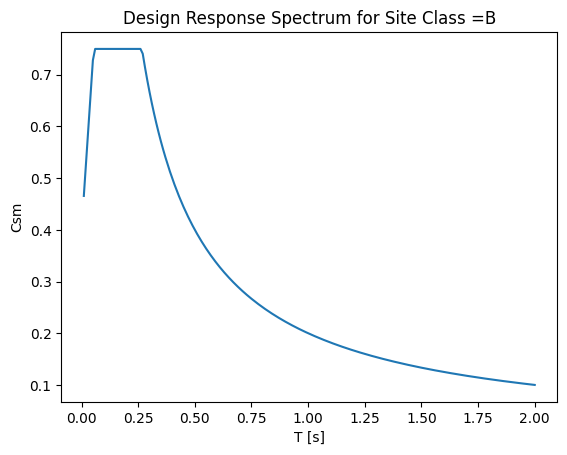

In [78]:
T_max=2
Plot(T_max,PGA, S_S, S_1, SiteClass)

In [79]:
tol=0.05
data_multimode, df_Example_1_0__multimode=Multimode(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k,tol, C_sm)

TypeError: loop of ufunc does not support argument 0 of type Float which has no callable sqrt method

In [80]:
np.sqrt(W_PP)

10.351811435686027